In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
import random

#from image import ImageDataGenerator
import os

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import RMSprop, Adadelta
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout, Reshape, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import model_from_json

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('keras','numpy','matplotlib','cv2')

Using Theano backend.


keras: 1.1.0
numpy: 1.11.2
matplotlib: 1.5.1
cv2: 2.4.10


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


## Setting

In [2]:
# path to data
path2numpy = "./output/data/"
foldnm=1
path2nfolds=path2numpy+'fold'+str(foldnm)+'/'

h,w=128,128
experiment='rcnn_hw_'+str(h)+'by'+str(w)
print 'experiment:', experiment

experiment: rcnn_hw_128by128


In [3]:
def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))

def image_with_mask(img, mask):
    maximg=np.max(img)
    mask=np.asarray(mask,dtype='uint8')
    if np.max(mask)<=1:
        mask=mask*255
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0
    #print np.sum(mask_edges)
    img_color[mask_edges, 0] = maximg  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    img_color=img_color/float(np.max(img))
    return img_color

# 5D array image display
def disp_img_mask_5d(img,mask=None,ind=None):
    # img and mask are 5d arrays, N*time*C*H*W
    #img=np.squeeze(img)
    
    # check for random dispaly or based on input
    if ind is None:
        n1=np.random.randint(img.shape[0])
    else:
        n1=ind

    I1=img[n1]
    print I1.shape
    
    if mask is None:
        M1=np.zeros(I1.shape,dtype='uint8')
    else:
        mask=np.squeeze(mask)
        M1=mask[n1,:]
    print M1.shape
    
    r,c=2,5
    for k in range(r*c):
        plt.subplot(r,c,k+1)
        imgmask=image_with_mask(I1[k,:],M1[k,:])
        plt.imshow(imgmask)
        plt.title('s: %s, maxI: %s' %(n1,np.max(I1[k,:])))
    plt.show()

# sample
def disp_img_mask(img,mask=None,r=1,c=1,shuffle=False,d=0):
    if mask is None:
        mask=np.zeros_like(img)
    
    N=np.min([r*c,img.shape[0]])
    if d==2:
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        mask=np.transpose(mask,(2,0,1))
        mask=np.expand_dims(mask,axis=1)
    
    if len(img.shape)==3:
        img=np.expand_dims(img,axis=1)
        mask=np.expand_dims(mask,axis=1)

        
    if shuffle is True:
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=range(0,N)
    
    #if d==0:    
    I1=img[n1,0]
    #M1=mask[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask.shape[1]):
        M1=np.logical_or(M1,mask[n1,c1,:])    
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k])
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    return n1        
    
    
# preprocess
def preprocess(Xin,param_prep):
    
    # get params
    h=param_prep['img_rows']
    w=param_prep['img_cols']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    z=param_prep['z']    
    
    Xout=np.empty((0,z,1,h,w),dtype='float32')
    N=len(Xin)
    for n in range(N):
        X=Xin[n]
        H,W=X.shape[1:]
        
        # center crop h*w
        if crop is 'center':
            hc=(H-h)/2
            wc=(W-w)/2
            X=X[:,hc:H-hc,wc:W-wc]
        elif crop is 'random':
            hc=(H-h)/2
            wc=(W-w)/2
            hcr=np.random.randint(hc)
            wcr=np.random.randint(wc)
            X=X[:,hc:H-hc,wc:W-wc]
        
        # resize if needed
        if h<H:
            X_r=np.zeros([z,h,w],dtype=X.dtype)
            for k1 in range(len(X)):
                X_r[k1] = cv2.resize(X[k1], (w, h), interpolation=cv2.INTER_CUBIC)
        else:
            X_r=X
    
        # normalization
        if norm_type is 'global':
            X_r=np.array(X_r,dtype='float32')
            X_r-=np.mean(X_r)
            X_r/=np.std(X_r)
        elif norm_type is 'local':
            for k in range(X_r.shape[0]):
                mean = np.mean(X_r[k,0])  # mean       
                sigma = np.std(X_r[k,0])  # std
                if sigma<1e-5:
                    sigma=1
                X_r[k] = X_r[k]-mean
                X_r[k] = X_r[k]/ sigma
        if z>X_r.shape[0]:
            X_r=np.append(X_r,np.zeros((z-X_r.shape[0],h,w),dtype='float32'),axis=0)
        else:
            z_random=np.random.randint(X_r.shape[0],size=z)
            X_r=X_r[z_random ]
        Xout=np.append(Xout,X_r[np.newaxis,:,np.newaxis,:],axis=0)
    return Xout


def array_stats(*args):
    for X in args:
        X=np.asarray(X)
        print 'array shape: ',X.shape, X.dtype
        #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
        print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))


        



## load data

In [4]:
# load train data
print 'wait ...'
f=np.load(path2nfolds + 'train.npz')
X_train=f['X']
y_train=f['Y']
N=300
X_train=X_train[:N]
y_train=y_train[:N]
print X_train.shape
print y_train.shape

f=np.load(path2nfolds + 'test.npz')
X_test=f['X']
y_test=f['Y']
print X_test.shape
print y_test.shape

wait ...
(300,)
(300,)
(280,)
(280,)


## sample data

subject: 200
slices: [ 32 138 135 171   0 156  46 137]
wait ...


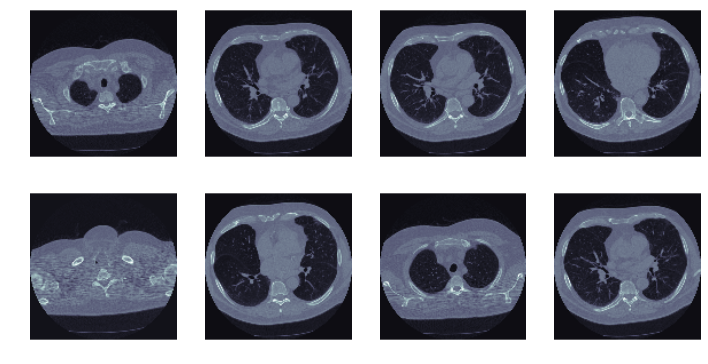

In [5]:
N_train=len(X_train)
N_test=len(X_test)

# display sample image
rnd_sbj=np.random.randint(N_train)
r,c=2,4
X=X_train[rnd_sbj]
nb_slices=len(X)
rnd_inds=np.random.randint(nb_slices,size=r*c)
print 'subject:', rnd_sbj
print 'slices:', rnd_inds
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print 'wait ...'
for i in range(r*c):
    plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(X[rnd_inds[i]], cmap=plt.cm.bone)

In [6]:
# pre-processing 
param_prep={
    'img_rows': 128,
    'img_cols': 128,
    'crop'    : None,
    'norm_type' : 'global',
    'z': 20,
}

print 'wait ...'
# preprocess train data
n1=3
X_train_r=preprocess(X_train[n1:n1+1],param_prep)
array_stats(X_train_r)

# preprocess test data
step=8
X_test_r=preprocess(X_test[n1:n1+step],param_prep)
array_stats(X_test_r)

from keras.utils import np_utils
y_train = np_utils.to_categorical(np.asarray(y_train,dtype='uint8'))
y_test = np_utils.to_categorical(np.asarray(y_test,dtype='uint8'))


wait ...
array shape:  (1, 20, 1, 128, 128) float32
min: -1.58333170414, max: 3.86847734451, avg: -0.0316, std:0.989
array shape:  (8, 20, 1, 128, 128) float32
min: -2.15161037445, max: 7.80548381805, avg: 0.000885, std:1.0


In [7]:
# define some run parameters
batch_size      = 1
nb_epochs       = 20
examplesPer     = X_train_r.shape[0]
timestep        = X_train_r.shape[1]
hidden_units    = 200
h,w= X_train_r.shape[3:5]

#define our time-distributed setup
model = Sequential()

model.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='same',activation='relu'), input_shape=(timestep,1,h,w)))
model.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))

model.add(TimeDistributed(Convolution2D(32, 3, 3, border_mode='same',activation='relu')))
#model.add(TimeDistributed(Convolution2D(32, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))

model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))
#model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))

model.add(TimeDistributed(Convolution2D(128, 3, 3, border_mode='same',activation='relu')))
#model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))

model.add(TimeDistributed(Convolution2D(256, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))
#model.add(TimeDistributed(Convolution2D(256, 3, 3, border_mode='same',activation='relu')))

model.add(TimeDistributed(Flatten()))
model.add(Activation('relu'))
model.add(GRU(output_dim=100,return_sequences=False))
#model.add(GRU(output_dim=50,return_sequences=False))
#model.add(Dropout(0.5))
model.add(Dense(2))

rmsprop = RMSprop()
model.compile(loss='binary_crossentropy', optimizer=rmsprop)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_1 (TimeDistribute(None, 20, 16, 128, 12160         timedistributed_input_1[0][0]    
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribute(None, 20, 16, 128, 122320        timedistributed_1[0][0]          
____________________________________________________________________________________________________
timedistributed_3 (TimeDistribute(None, 20, 16, 64, 64)0           timedistributed_2[0][0]          
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribute(None, 20, 32, 64, 64)4640        timedistributed_3[0][0]          
___________________________________________________________________________________________

In [8]:
print 'train in progress ...'

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2weights=weightfolder+"/weights.hdf5"

# checkpoint settings
checkpoint = ModelCheckpoint(path2weights, monitor='val_loss', verbose=0, save_best_only='True',mode='min')

# Fit the model
# number of epochs
nb_epoch=500
start_time=time.time()
score_train=[]
score_test=[]

for epoch in range(nb_epoch):
    print '-'*50
    print 'epoch: %s' %epoch
    seed = np.random.randint(0, 999999)

    # augment training
    #Xaug,Yaug=iterate_minibatches( X_train, Y_train , X_train.shape[0], shuffle=False)
    #X_train_aug,Y_train_aug=preprocess(Xaug,Yaug,param_prep)
    #_,y_train_aug=mask2volume(Y_train_aug)
    #X_train_aug=X_train_r
    #disp_img_mask(X_train_aug,Y_train_aug)
    step=8
    for n1 in range(0,len(X_train),step):
        X_train_r=preprocess(X_train[n1:n1+step],param_prep)
        y_train_r=y_train[n1:n1+step]
        model.fit(X_train_r, y_train_r,nb_epoch=1, batch_size=step,verbose=0,shuffle=True)
    
    s_train=[]
    for n1 in range(0,len(X_train),step):
        X_train_r=preprocess(X_train[n1:n1+step],param_prep)
        y_train_r=y_train[n1:n1+step]
        s_train.append(model.evaluate(X_train_r, y_train_r,verbose=0))
    
    s_test=[]
    for n1 in range(0,len(X_test),step):
        X_test_r=preprocess(X_test[n1:n1+step],param_prep)
        y_test_r=y_test[n1:n1+step]
        s_test.append(model.evaluate(X_test_r, y_test_r,verbose=0))

    print 'loss train: %.5f, loss test: %.5f ' %(np.mean(s_train),np.mean(s_test))    

    score_train=np.append(score_train,np.mean(s_train))
    score_test=np.append(score_test,np.mean(s_test))    

plt.plot(score_train)
plt.plot(score_test)

train in progress ...
--------------------------------------------------
epoch: 0
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 1
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 2
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 3
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 4
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 5
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 6
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 7
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 8
loss train: 7.97119, loss test: 7.97119 
--------------------------------------------------
epoch: 9
loss trai

MemoryError: Error allocating 167772160 bytes of device memory (out of memory).
Apply node that caused the error: GpuAllocEmpty(Elemwise{Composite{((i0 * i1 * i2 * i3 * i4) // i5)}}[(0, 0)].0, Shape_i{0}.0, Elemwise{Composite{((((i0 + (i1 * (i2 // i1))) - i2) // i3) + i3)}}[(0, 2)].0, Elemwise{Composite{((((i0 + (i1 * (i2 // i1))) - i2) // i3) + i3)}}[(0, 2)].0)
Toposort index: 79
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(160), array(16), array(128), array(128)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
y_train_r=y_train[n1:n1+2]
print y_train_r.shape

In [ ]:
weights_path="./output/weights/fold"+str(foldnm)+"-volume_weights.hdf5"
print weights_path
model.load_weights(weights_path)

s_train=model.evaluate(X_train_aug, y_train_aug,verbose=0)
s_test=model.evaluate(X_test_r, y_test,verbose=0)
print 'train: %.5f' %s_train    
print 'test: %.5f' %s_test

y_pred1=model.predict(X_train_aug)
#y_pred1=np.reshape(y_pred1,(1,y_pred1.shape[0]))
y_pred2=model.predict(X_test_r)
v_train,_=mask2volume(Y_train_aug)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(v_train)
y_pred1=np.max(v_train)*y_pred1
plt.plot(y_pred1)
plt.title('train')

plt.subplot(1,2,2)
v_test,_=mask2volume(Y_test)
y_pred2=np.max(v_test)*y_pred2
plt.plot(v_test)
plt.plot(y_pred2)
plt.title('test')
plt.legend('ground truth','automatic',loc='upper right')
plt.show()

In [ ]:
xaug,yaug=iterate_minibatches( X_train, Y_train , X_train.shape[0], shuffle=False)
Xaug,Yaug=preprocess(xaug,yaug,param_prep)
print np.max(xaug)
# display sample image
plt.figure(figsize=(20,10)) 
disp_img_mask(Xaug,Yaug)

vaug,vaugn=mask2volume(Yaug)
print vaug,vaugn